# Human Observed Data- Linear and Logistic Regression

# Importing all the necessary modules

In [1]:
from sklearn.cluster import KMeans
import tensorflow as tf
import numpy as np
import csv
import math
import matplotlib.pyplot
from itertools import islice
from matplotlib import pyplot as plt
import random

# Preprocessing of the files

In [2]:
def concatenate(filepath1,filepath2,filepath3,noOfLines):
    with open(filepath1, 'w',newline='') as myfile:
        wr = csv.writer(myfile)
        with open(filepath2, 'r') as fi:
            reader = csv.reader(fi)
            writer = csv.writer(fi)
            dataRows = []
            for row in islice(reader,1,noOfLines):
                #print(len(fi.readlines()))
                dataRow=[]
                dataRow.append(row[0])
                dataRow.append(row[1])
                dataRow.append(int(row[2]))
                for column in islice(row,0,2):
                    with open(filepath3, 'r') as fi2:
                        reader1 = csv.reader(fi2)
                        for row2 in islice(reader1,1,1028):
                            for column2 in row2:
                                 if(column2==column):
                                    content = list(row2[i] for i in range(2,11))
                                    for word in content:
                                        dataRow.append(word)
                dataRows.append(dataRow)
            # wr.writerow(dataRow)
            #print(dataRows)
            wr.writerows(dataRows)
           # print(dataRow)
            
def subtract(filepath1,filepath2,noOfLines):
    with open(filepath1, 'w',newline='') as myfile:
        wr = csv.writer(myfile)
        with open(filepath2, 'r') as fi:
            #c=(len(fi.readlines()))
            reader = csv.reader(fi)
            writer = csv.writer(fi)
        
            for row in islice(reader,0,noOfLines):
                list=[]
    
                list.append(row[0])
                list.append(row[1])
                list.append(int(row[2]))
                for i in range(2,11):
                    list.append(abs(int(row[i])-int(row[i+9])))
                wr.writerow(list)
                

def combine_pairs(filepath1,filepath2,filepath3):
    fout=open(filepath1,"w",newline='')
    for line in open(filepath2):
         fout.write(line)
            
    with open(filepath3, "r") as source:
        lines = [line for line in source]
    random_choice = random.sample(lines, 791)
    for l in random_choice:
        fout.write(l)
    fout.close()
    
def shuffled_pairs(filepath1,filepath2):
    
    fid = open(filepath2, "r")
    li = fid.readlines()
    fid.close()
    #print(li)

    random.shuffle(li)
    #print(li)

    fid = open(filepath1, "w",newline='')
    fid.writelines(li)
    fid.close()

In [3]:
#Creating a vector consisting only of target values by using the preprocessed shuffled_pairs file

def GetTarget(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(float(row[2]))
        #print("Raw Training Generated..")
    
    return t

def GetRawData(filePath):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row[3:]:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    
    #dataMatrix = np.delete(dataMatrix, [0,1,2], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    
    
    return dataMatrix

#Generating training target from raw target by restricting the length of the training target to only 80% of whole raw target.
def GenerateTrainingTarget(rawTraining,TrainingPercent):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    #From the beginning to the calculated training length
    t           = rawTraining[:TrainingLen]
   # print(str(TrainingPercent) + "% Training Target Generated..")
    return t


#Generating training data from whole dataset by restricting the length of the  training dataset to be only 80% of whole raw dataset.
def GenerateTrainingDataMatrix(rawData, TrainingPercent):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
   # print(str(TrainingPercent) + "% Training Data Generated..")
    return d2


#Generating validation/testing target from raw target by restricting the length of the validation/testing target to be only 10% of whole raw target.
def GenerateTargetData(rawData,ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#Generating validation/testing data from whole dataset by restricting the length of the validation/testing dataset to only 10% of whole dataset
def GenerateTargetVector(rawData,ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    return t

In [4]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
#     if IsSynthetic == True:
#         BigSigma = np.dot(3,BigSigma)
#     else:
    BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W



def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [5]:
concatenate('humanobserved/concatenated_same_pairs.csv','humanobserved/same_pairs.csv','humanobserved/HumanObserved-Features-Data.csv',792)
subtract('humanobserved/subtracted_same_pairs.csv','humanobserved/concatenated_same_pairs.csv',791)
concatenate('humanobserved/concatenated_diff_pairs.csv','humanobserved/diffn_pairs.csv','humanobserved/HumanObserved-Features-Data.csv',1000)
subtract('humanobserved/subtracted_diff_pairs.csv','humanobserved/concatenated_diff_pairs.csv',1000)
combine_pairs('humanobserved/concatenated_pairs.csv','humanobserved/concatenated_same_pairs.csv','humanobserved/concatenated_diff_pairs.csv');
combine_pairs('humanobserved/subtracted_pairs.csv','humanobserved/subtracted_same_pairs.csv','humanobserved/subtracted_diff_pairs.csv');
shuffled_pairs('humanobserved/shuffled_concatenated_pairs.csv','humanobserved/concatenated_pairs.csv');
shuffled_pairs('humanobserved/shuffled_subtracted_pairs.csv','humanobserved/subtracted_pairs.csv');

#RawTarget
rawConcatenatedTarget = GetTarget('humanobserved/shuffled_concatenated_pairs.csv')
rawSubtractedTarget = GetTarget('humanobserved/shuffled_subtracted_pairs.csv')
#RawData
rawConcatenatedData=GetRawData('humanobserved/shuffled_concatenated_pairs.csv')
rawSubtractedData=GetRawData('humanobserved/shuffled_subtracted_pairs.csv')
# print(rawConcatenatedData.shape)
# print(rawSubtractedData.shape)
#splitting
TrainingPercent=80;
ValidationPercent=10;
TestPercent=10;
ConcatenatedTrainingTarget = np.array(GenerateTrainingTarget(rawConcatenatedTarget,TrainingPercent))
ConcatenatedTrainingDataMatrix   = GenerateTrainingDataMatrix(rawConcatenatedData,TrainingPercent)
print("The shape of ConcatenatedTrainingTarget is ", ConcatenatedTrainingTarget.shape)
print("The shape of ConcatenatedTrainingDataMatrix is ",ConcatenatedTrainingDataMatrix.shape)

ConcatenatedValidationTarget = np.array(GenerateTargetVector(rawConcatenatedTarget,ValidationPercent, (len(ConcatenatedTrainingTarget))))
ConcatenatedValidationDataMatrix    = GenerateTargetData(rawConcatenatedData,ValidationPercent, (len(ConcatenatedTrainingTarget)))

print("The shape of ConcatenatedValidationTarget is ", ConcatenatedValidationTarget.shape)
print("The shape of ConcatenatedValidationDataMatrix is ",ConcatenatedValidationDataMatrix.shape)
ConcatenatedTestingTarget = np.array(GenerateTargetVector(rawConcatenatedTarget,TestPercent, (len(ConcatenatedTrainingTarget)+len(ConcatenatedValidationTarget))))
ConcatenatedTestingDataMatrix = GenerateTargetData(rawConcatenatedData,TestPercent, (len(ConcatenatedTrainingTarget)+len(ConcatenatedValidationTarget)))

print("The shape of ConcatenatedTestingTarget is ", ConcatenatedTestingTarget.shape)
print("The shape of ConcatenatedTestingDataMatrix is ",ConcatenatedTestingDataMatrix.shape)
#subtracted

SubtractedTrainingTarget = np.array(GenerateTrainingTarget(rawSubtractedTarget,TrainingPercent))
SubtractedTrainingDataMatrix   = GenerateTrainingDataMatrix(rawSubtractedData,TrainingPercent)
SubtractedValidationTarget = np.array(GenerateTargetVector(rawSubtractedTarget,ValidationPercent, (len(SubtractedTrainingTarget))))
SubtractedValidationDataMatrix    = GenerateTargetData(rawSubtractedData,ValidationPercent, (len(SubtractedTrainingTarget)))
SubtractedTestingTarget = np.array(GenerateTargetVector(rawSubtractedTarget,TestPercent, (len(SubtractedTrainingTarget)+len(SubtractedValidationTarget))))
SubtractedTestingDataMatrix = GenerateTargetData(rawSubtractedData,TestPercent, (len(SubtractedTrainingTarget)+len(SubtractedValidationTarget)))
print("The shape of SubtractedTrainingTarget is ", SubtractedTrainingTarget.shape)
print("The shape of SubtractedTrainingDataMatrix is ",SubtractedTrainingDataMatrix.shape)
print("The shape of SubtractedValidationTarget is ", SubtractedValidationTarget.shape)
print("The shape of SubtractedValidationDataMatrix is ",SubtractedValidationDataMatrix.shape)
print("The shape of SubtractedTestingTarget is ", SubtractedTestingTarget.shape)
print("The shape of SubtractedTestingDataMatrix is ",SubtractedTestingDataMatrix.shape)

The shape of ConcatenatedTrainingTarget is  (1266,)
The shape of ConcatenatedTrainingDataMatrix is  (18, 1266)
The shape of ConcatenatedValidationTarget is  (158,)
The shape of ConcatenatedValidationDataMatrix is  (18, 158)
The shape of ConcatenatedTestingTarget is  (157,)
The shape of ConcatenatedTestingDataMatrix is  (18, 157)
The shape of SubtractedTrainingTarget is  (1266,)
The shape of SubtractedTrainingDataMatrix is  (9, 1266)
The shape of SubtractedValidationTarget is  (158,)
The shape of SubtractedValidationDataMatrix is  (9, 158)
The shape of SubtractedTestingTarget is  (157,)
The shape of SubtractedTestingDataMatrix is  (9, 157)


c:\users\ravali pinnaka\desktop\python\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """
c:\users\ravali pinnaka\desktop\python\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 'U' mode is deprecated
  from ipykernel import kernelapp as app


# Linear Regression

# # Human Observed Data with Feature Concatenation

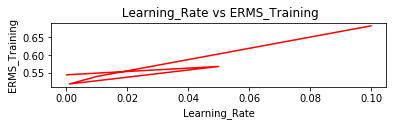

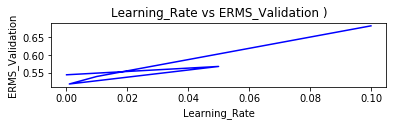

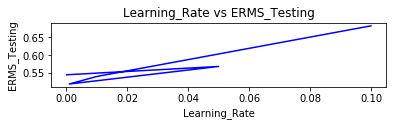

Erms Values
+--------------+--------+-----------+-------------+---------------+------------+
| Learning Rat | Lambda | Iteration | ErmsTrainin | ErmsValidatio | ErmsTestin |
|      e       |        |           |      g      |       n       |     g      |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.1      |  0.1   |    100    |    0.726    |     0.713     |    0.69    |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.01     |  0.1   |    100    |    0.51     |     0.512     |   0.513    |
+--------------+--------+-----------+-------------+---------------+------------+
|    0.001     |  0.1   |    100    |    0.51     |     0.512     |   0.514    |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.05     |  0.1   |    100    |    0.602    |     0.592     |   0.576    |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.0      |

In [6]:
from beautifultable import BeautifulTable 
ErmsTable = BeautifulTable()
AccuracyTable = BeautifulTable()
AccuracyTable.column_headers = ["Learning Rate", "Lambda","Iteration", "AccuracyTraining","AccuarcyValidation","AccuracyTesting","difference"]
ErmsTable.column_headers = ["Learning Rate", "Lambda","Iteration", "ErmsTraining","ErmsValidation","ErmsTesting"]


TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
ErmsArr = []
AccuracyArr = []
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(ConcatenatedTrainingDataMatrix))
Mu = kmeans.cluster_centers_
BigSigma     = GenerateBigSigma(rawConcatenatedData, Mu, TrainingPercent)
TRAINING_PHI = GetPhiMatrix(rawConcatenatedData, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(ConcatenatedTestingDataMatrix, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ConcatenatedValidationDataMatrix, Mu, BigSigma, 100)
W   = tf.Variable(tf.random_normal([M,],stddev=0.01))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
W_Now = W.eval(sess)
La           = 0.1
learningRate = [0.1,0.01,0.001,0.05,0.0001]
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []
itr=[100,400,500]
graph_tr=[]
graph_val=[]
graph_test=[]
for it in itr:
    E_tr=[]
    E_val=[]
    E_test=[]
    for lr in learningRate:
        Erms_TR=""
        Erms_Val =""
        Erms_Test=""
        for i in range(0,it):
           
           
            #print ('---------Iteration: ' + str(i) + '--------------')
            Delta_E_D     = -np.dot((ConcatenatedTrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
            Delta_W       = -np.dot(lr,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next

            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
           # print(TR_TEST_OUT)
            Erms_TR       = GetErms(TR_TEST_OUT,ConcatenatedTrainingTarget)
            L_Erms_TR.append(float(Erms_TR.split(',')[1]))
            L_Acc_Val.append(float(Erms_TR.split(',')[0]))

            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
            Erms_Val      = GetErms(VAL_TEST_OUT,ConcatenatedValidationTarget)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))
            L_Acc_Val.append(float(Erms_Val.split(',')[0]))

            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
            Erms_Test = GetErms(TEST_OUT,ConcatenatedTestingTarget)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            L_Acc_Val.append(float(Erms_Test.split(',')[0]))
        ErmsTable.append_row([lr,La,it,str(float(Erms_TR.split(',')[1])),str(float(Erms_Val.split(',')[1])),str(float( Erms_Test.split(',')[1]))])
        E_tr.append(float(Erms_Test.split(',')[1]))
        E_val.append(float(Erms_Test.split(',')[1]))
        E_test.append(float(Erms_Test.split(',')[1]))
        AccuracyTable.append_row([lr,La,it,str(float(Erms_TR.split(',')[0])),str(float(Erms_Val.split(',')[0])),str(float( Erms_Test.split(',')[0])),float( Erms_TR.split(',')[0])-float(Erms_Val.split(',')[0])])
    if it==500:
        graph_tr=E_tr
        graph_val=E_val
        graph_test=E_test

plt.subplot(3,1,1)
plt.plot (learningRate,graph_tr,'r')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Training')
plt.title(' Learning_Rate vs ERMS_Training')

plt.show()

plt.subplot(3,1,2)
plt.plot (learningRate, graph_val,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Validation')
plt.title('Learning_Rate vs ERMS_Validation )')

plt.show()

plt.subplot(3,1,3)
plt.plot (learningRate,graph_test,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Testing')
plt.title('Learning_Rate vs ERMS_Testing')

plt.show()  


print('Erms Values')
print(ErmsTable) 
print('Accuracy Values') 
print(AccuracyTable)

# # Human Observed Data with Feature Subtraction

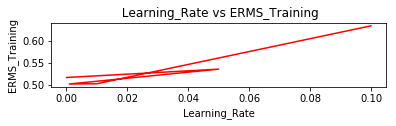

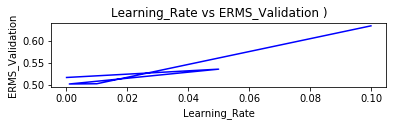

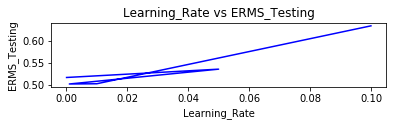

Erms Values
+--------------+--------+-----------+-------------+---------------+------------+
| Learning Rat | Lambda | Iteration | ErmsTrainin | ErmsValidatio | ErmsTestin |
|      e       |        |           |      g      |       n       |     g      |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.1      |  0.1   |    100    |    0.691    |     0.698     |   0.679    |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.01     |  0.1   |    100    |    0.513    |     0.515     |    0.51    |
+--------------+--------+-----------+-------------+---------------+------------+
|    0.001     |  0.1   |    100    |    0.505    |     0.505     |   0.503    |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.05     |  0.1   |    100    |    0.566    |     0.571     |   0.559    |
+--------------+--------+-----------+-------------+---------------+------------+
|     0.0      |

In [7]:
# #subtracted linear
from beautifultable import BeautifulTable 
ErmsTable = BeautifulTable()
AccuracyTable = BeautifulTable()
AccuracyTable.column_headers = ["Learning Rate", "Lambda","Iteration", "AccuracyTraining","AccuarcyValidation","AccuracyTesting","difference"]
ErmsTable.column_headers = ["Learning Rate", "Lambda","Iteration", "ErmsTraining","ErmsValidation","ErmsTesting"]
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
#Create 9 clusters or use 9 basis functions
kmeans = KMeans(n_clusters=9, random_state=0).fit(np.transpose(SubtractedTrainingDataMatrix))
Mu = kmeans.cluster_centers_
BigSigma     = GenerateBigSigma(rawSubtractedData, Mu, TrainingPercent)
TRAINING_PHI = GetPhiMatrix(rawSubtractedData, Mu, BigSigma, TrainingPercent)
TEST_PHI     = GetPhiMatrix(SubtractedTestingDataMatrix, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(SubtractedValidationDataMatrix, Mu, BigSigma, 100)

#Randomly choose 9  weights as there are 9 features
W   = tf.Variable(tf.random_normal([9,],stddev=0.01))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
W_Now = W.eval(sess)
La           = 0.1
learningRate = [0.1,0.01,0.001,0.05,0.0001]
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []
itr=[100,400,500]
graph_tr=[]
graph_val=[]
graph_test=[]
for it in itr:
    E_tr=[]
    E_val=[]
    E_test=[]
    for lr in learningRate:
        Erms_TR=""
        Erms_Val =""
        Erms_Test=""
        for i in range(0,it):

    
            #print ('---------Iteration: ' + str(i) + '--------------')
            Delta_E_D     = -np.dot((SubtractedTrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
            Delta_W       = -np.dot(lr,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next

            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
           # print(TR_TEST_OUT)
            Erms_TR       = GetErms(TR_TEST_OUT,SubtractedTrainingTarget)
            L_Erms_TR.append(float(Erms_TR.split(',')[1]))
            L_Acc_TR.append(float(Erms_TR.split(',')[0]))
            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
            Erms_Val      = GetErms(VAL_TEST_OUT,SubtractedValidationTarget)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))
            L_Acc_Val.append(float(Erms_TR.split(',')[0]))
            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
            Erms_Test = GetErms(TEST_OUT,SubtractedTestingTarget)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            L_Acc_Test.append(float(Erms_TR.split(',')[0]))
        ErmsTable.append_row([lr,La,it,str(float(Erms_TR.split(',')[1])),str(float(Erms_Val.split(',')[1])),str(float( Erms_Test.split(',')[1]))])
        E_tr.append(float(Erms_Test.split(',')[1]))
        E_val.append(float(Erms_Test.split(',')[1]))
        E_test.append(float(Erms_Test.split(',')[1]))
        AccuracyTable.append_row([lr,La,it,str(float(Erms_TR.split(',')[0])),str(float(Erms_Val.split(',')[0])),str(float( Erms_Test.split(',')[0])),float( Erms_TR.split(',')[0])-float(Erms_Val.split(',')[0])])
    if it==500:
        graph_tr=E_tr
        graph_val=E_val
        graph_test=E_test


import matplotlib.pyplot as plt
%matplotlib inline


plt.subplot(3,1,1)
plt.plot (learningRate,graph_tr,'r')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Training')
plt.title(' Learning_Rate vs ERMS_Training')

plt.show()

plt.subplot(3,1,2)
plt.plot (learningRate, graph_val,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Validation')
plt.title('Learning_Rate vs ERMS_Validation )')

plt.show()

plt.subplot(3,1,3)
plt.plot (learningRate,graph_test,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Testing')
plt.title('Learning_Rate vs ERMS_Testing')

plt.show()   


#print(graph_tr)

print('Erms Values')
print(ErmsTable) 
print('Accuracy Values') 
print(AccuracyTable)

# Logistic Regression

In [8]:

def GetSigmoid(z):    
   
    return 1 / (1 + np.exp(-z))


def SigmoidValTest(VAL_PHI,W):

    z = np.dot(np.transpose(VAL_PHI),W)
    h = GetSigmoid(z)
    return h

# #	Human Observed Dataset with feature concatentation

c:\users\ravali pinnaka\desktop\python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


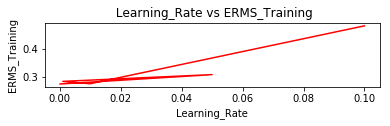

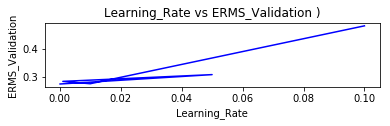

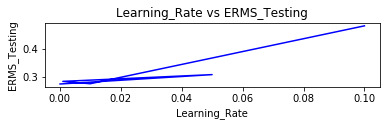

Erms Values
+-----------------+-----------+--------------+-------------------+-------------+
|  Learning Rate  | Iteration | ErmsTraining |  ErmsValidation   | ErmsTesting |
+-----------------+-----------+--------------+-------------------+-------------+
|       0.1       |    100    |     0.37     |       0.344       |    0.399    |
+-----------------+-----------+--------------+-------------------+-------------+
|      0.01       |    100    |    0.258     |       0.211       |    0.317    |
+-----------------+-----------+--------------+-------------------+-------------+
|      0.001      |    100    |    0.258     |       0.212       |    0.318    |
+-----------------+-----------+--------------+-------------------+-------------+
|      0.05       |    100    |    0.591     |       0.562       |    0.614    |
+-----------------+-----------+--------------+-------------------+-------------+
|       0.0       |    100    |    0.303     |       0.29        |    0.378    |
+---------------

In [9]:
from beautifultable import BeautifulTable 
ErmsTable = BeautifulTable()
AccuracyTable = BeautifulTable()
AccuracyTable.column_headers = ["Learning Rate","Iteration", "AccuracyTraining","AccuarcyValidation","AccuracyTesting","difference"]
ErmsTable.column_headers = ["Learning Rate","Iteration", "ErmsTraining","ErmsValidation","ErmsTesting"]

M=18
W   = tf.Variable(tf.random_normal([18,],stddev=0.01))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
W_Now = W.eval(sess)

learningRate = [0.1,0.01,0.001,0.05,0.0001]
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []
itr=[100,400,500]
graph_tr=[]
graph_val=[]
graph_test=[]
for it in itr:
    E_tr=[]
    E_val=[]
    E_test=[]
    for lr in learningRate:
        Erms_TR=""
        Erms_Val =""
        Erms_Test=""
        for i in range(0,it):


            Delta_E       =  np.dot(SigmoidValTest(ConcatenatedTrainingDataMatrix,W_Now)-ConcatenatedTrainingTarget,np.transpose(ConcatenatedTrainingDataMatrix))


            Delta_W       = -np.dot(lr,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next

            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = SigmoidValTest(ConcatenatedTrainingDataMatrix,W_T_Next) 
           # print(TR_TEST_OUT)
            Erms_TR       = GetErms(TR_TEST_OUT,ConcatenatedTrainingTarget)
            L_Erms_TR.append(float(Erms_TR.split(',')[1]))
            L_Acc_TR.append(float(Erms_TR.split(',')[0]))
            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = SigmoidValTest(ConcatenatedValidationDataMatrix,W_T_Next) 
            Erms_Val      = GetErms(VAL_TEST_OUT,ConcatenatedValidationTarget)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))
            L_Acc_Val.append(float(Erms_TR.split(',')[0]))
            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = SigmoidValTest(ConcatenatedTestingDataMatrix,W_T_Next) 
            Erms_Test = GetErms(TEST_OUT,ConcatenatedTestingTarget)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            L_Acc_Test.append(float(Erms_TR.split(',')[0]))
        ErmsTable.append_row([lr,it,str(float(Erms_TR.split(',')[1])),str(float(Erms_Val.split(',')[1])),str(float( Erms_Test.split(',')[1]))])
        E_tr.append(float(Erms_Test.split(',')[1]))
        E_val.append(float(Erms_Test.split(',')[1]))
        E_test.append(float(Erms_Test.split(',')[1]))
        AccuracyTable.append_row([lr,it,str(float(Erms_TR.split(',')[0])),str(float(Erms_Val.split(',')[0])),str(float( Erms_Test.split(',')[0])),float( Erms_TR.split(',')[0])-float(Erms_Val.split(',')[0])])
    if it==500:
        graph_tr=E_tr
        graph_val=E_val
        graph_test=E_test

import matplotlib.pyplot as plt
%matplotlib inline


plt.subplot(3,1,1)
plt.plot (learningRate,graph_tr,'r')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Training')
plt.title(' Learning_Rate vs ERMS_Training')

plt.show()

plt.subplot(3,1,2)
plt.plot (learningRate, graph_val,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Validation')
plt.title('Learning_Rate vs ERMS_Validation )')

plt.show()

plt.subplot(3,1,3)
plt.plot (learningRate,graph_test,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Testing')
plt.title('Learning_Rate vs ERMS_Testing')

plt.show()   



print('Erms Values')
print(ErmsTable) 
print('Accuracy Values') 
print(AccuracyTable)

# # Human Observed data with Feature Subtraction

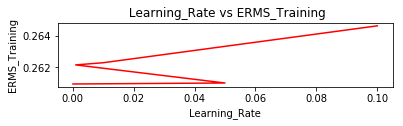

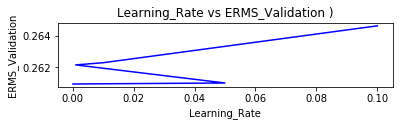

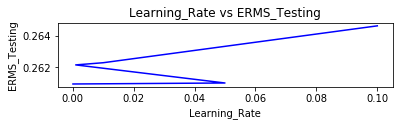

Erms Values
+-----------------+-----------+--------------+-------------------+-------------+
|  Learning Rate  | Iteration | ErmsTraining |  ErmsValidation   | ErmsTesting |
+-----------------+-----------+--------------+-------------------+-------------+
|       0.1       |    100    |    0.207     |       0.19        |    0.274    |
+-----------------+-----------+--------------+-------------------+-------------+
|      0.01       |    100    |    0.204     |       0.19        |    0.264    |
+-----------------+-----------+--------------+-------------------+-------------+
|      0.001      |    100    |    0.204     |       0.19        |    0.264    |
+-----------------+-----------+--------------+-------------------+-------------+
|      0.05       |    100    |    0.201     |       0.188       |    0.261    |
+-----------------+-----------+--------------+-------------------+-------------+
|       0.0       |    100    |    0.201     |       0.188       |    0.261    |
+---------------

In [10]:
from beautifultable import BeautifulTable 
ErmsTable = BeautifulTable()
AccuracyTable = BeautifulTable()
AccuracyTable.column_headers = ["Learning Rate","Iteration", "AccuracyTraining","AccuarcyValidation","AccuracyTesting","difference"]
ErmsTable.column_headers = ["Learning Rate","Iteration", "ErmsTraining","ErmsValidation","ErmsTesting"]
M=9
W   = tf.Variable(tf.random_normal([9,],stddev=0.01))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
W_Now = W.eval(sess)
learningRate = [0.1,0.01,0.001,0.05,0.0001]
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []
itr=[100,400,500]
graph_tr=[]
graph_val=[]
graph_test=[]
for it in itr:
    E_tr=[]
    E_val=[]
    E_test=[]
    for lr in learningRate:
        Erms_TR=""
        Erms_Val =""
        Erms_Test=""
        for i in range(0,it):


            Delta_E       =  np.dot(SigmoidValTest(SubtractedTrainingDataMatrix,W_Now)-SubtractedTrainingTarget,np.transpose(SubtractedTrainingDataMatrix))


            Delta_W       = -np.dot(lr,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next

            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = SigmoidValTest(SubtractedTrainingDataMatrix,W_T_Next) 
           # print(TR_TEST_OUT)
            Erms_TR       = GetErms(TR_TEST_OUT,SubtractedTrainingTarget)
            L_Erms_TR.append(float(Erms_TR.split(',')[1]))
            L_Acc_TR.append(float(Erms_TR.split(',')[0]))
            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = SigmoidValTest(SubtractedValidationDataMatrix,W_T_Next) 
            Erms_Val      = GetErms(VAL_TEST_OUT,SubtractedValidationTarget)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))
            L_Acc_Val.append(float(Erms_TR.split(',')[0]))
            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = SigmoidValTest(SubtractedTestingDataMatrix,W_T_Next) 
            Erms_Test = GetErms(TEST_OUT,SubtractedTestingTarget)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            L_Acc_Test.append(float(Erms_TR.split(',')[0]))
        ErmsTable.append_row([lr,it,str(float(Erms_TR.split(',')[1])),str(float(Erms_Val.split(',')[1])),str(float( Erms_Test.split(',')[1]))])
        E_tr.append(float(Erms_Test.split(',')[1]))
        E_val.append(float(Erms_Test.split(',')[1]))
        E_test.append(float(Erms_Test.split(',')[1]))
        AccuracyTable.append_row([lr,it,str(float(Erms_TR.split(',')[0])),str(float(Erms_Val.split(',')[0])),str(float( Erms_Test.split(',')[0])),float( Erms_TR.split(',')[0])-float(Erms_Val.split(',')[0])])
    if it==500:
        graph_tr=E_tr
        graph_val=E_val
        graph_test=E_test


import matplotlib.pyplot as plt
%matplotlib inline


plt.subplot(3,1,1)
plt.plot (learningRate,graph_tr,'r')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Training')
plt.title(' Learning_Rate vs ERMS_Training')

plt.show()

plt.subplot(3,1,2)
plt.plot (learningRate, graph_val,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Validation')
plt.title('Learning_Rate vs ERMS_Validation )')

plt.show()

plt.subplot(3,1,3)
plt.plot (learningRate,graph_test,'b')
plt.xlabel('Learning_Rate')
plt.ylabel('ERMS_Testing')
plt.title('Learning_Rate vs ERMS_Testing')

plt.show()   


#print(graph_tr)

print('Erms Values')
print(ErmsTable) 
print('Accuracy Values') 
print(AccuracyTable)